# Thermodynamics of learning by Entropic dynamics in Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy import linalg as LA
from sklearn.datasets import make_spd_matrix

In [2]:
def F(u, noise= 0.1):
    const = (1-2*noise)/np.sqrt(2*np.pi)
    phi = norm.cdf(u)
    f = const*np.exp(-0.5*u*u) / (noise + (1- 2*noise)*phi)
    return f

def dF(u, noise= 0.1):

    df = -F(u, noise)*(u + F(u, noise))
    
    return df

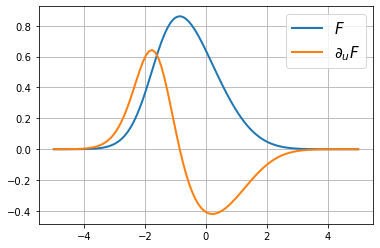

In [5]:
u = np.linspace(-5, 5, 100)
plt.plot(u, F(u), label= '$F$', linewidth= 2)
plt.plot(u, dF(u), label= '$\partial_{u} F$', linewidth= 2)
plt.legend(fontsize= 15)
plt.grid()
plt.show()

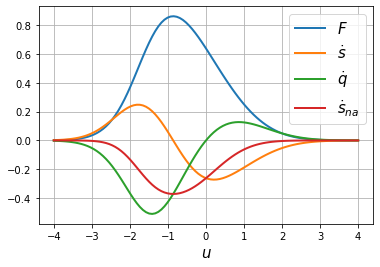

In [6]:
u = np.linspace(-4, 4, 100)
noise = 0.1


s = np.log(1 + dF(u, noise= noise))/2
q = -(dF(u, noise= noise) + F(u)*F(u))/2
s_na = s + q

plt.plot(u, F(u, noise= noise), label= '$F$', linewidth= 2, color= 'C0')
plt.plot(u, s, label= '$\dot{s}$', linewidth= 2, color= 'C1')
plt.plot(u, q, label= '$\dot{q}$', linewidth= 2, color= 'C2')
plt.plot(u, s_na, label= '$\dot{s}_{na}$', linewidth= 2, color= 'C3')
plt.xlabel('$u$', fontsize= 15)
plt.grid()
plt.legend(fontsize= 15)
plt.show()

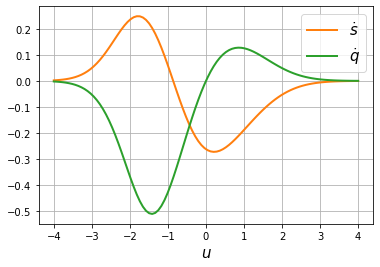

In [7]:
u = np.linspace(-4, 4, 100)
noise = 0.1


s = np.log(1 + dF(u, noise= noise))/2
q = -(dF(u, noise= noise) + F(u)*F(u))/2
s_na = s + q

#plt.plot(u, F(u, noise= noise), label= '$F$', linewidth= 2, color= 'C0')
plt.plot(u, s, label= '$\dot{s}$', linewidth= 2, color= 'C1')
plt.plot(u, q, label= '$\dot{q}$', linewidth= 2, color= 'C2')
#plt.plot(u, s_na, label= '$\dot{s}_{na}$', linewidth= 2, color= 'C3')
plt.xlabel('$u$', fontsize= 15)
plt.grid()
plt.legend(fontsize= 15)
plt.show()

## Entropic dynamics

In [8]:
N = 100
M = 600

### The teacher

In [9]:
w_B = np.ones(N)

In [10]:
x_train = np.random.randn(M, N)
y_train = np.array([np.sign(np.dot(x_train[j], w_B)) for j in range(M)])

Initialize weights

In [11]:
### Initialize

w = np.random.randn(N)             # Gaussian random weights
#C = np.random.rand(N, N)          # Uniform random correlations
#C = np.matmul(C, C.T)             # Make C0 symmetric, positive-definite 
#C = C / np.max(C)                 # Keep C0_{jk} small

# or sklearn option
C = make_spd_matrix(N, random_state= 12)


# Delta S
S_ = []
# Delta q
q_ = []
# Overlap rho
rho_ = []
# C
C_ = []
# w
w_ = []

# Dynamics
for t in range(M):
    
    gamma = np.dot(x_train[t].T, np.matmul(C, x_train[t])) / N
    u = np.dot(w, x_train[t])*y_train[t] / np.sqrt(gamma*N)
    v = np.matmul(C, x_train[t])

    w_new = w + (1./np.sqrt(gamma*N)) * y_train[t]* F(u, noise= 0.1)*np.matmul(x_train[t], C)
    C_new = C + (1./(gamma*N)) * dF(u, noise= 0.1) * np.outer(v, v.T)


    # Monitor    
    #traceC_.append(np.trace(C_new))
    S_.append(np.log(1+dF(u, noise= 0.1))/2)
    q_.append(-F(u, noise= 0.1)*F(u, noise= 0.1)/2  -dF(u, noise= 0.1)/2 )
    rho_.append(np.dot(w_new, w_B) / ( LA.norm(w_new)*LA.norm(w_B) ))
    C_.append(C_new)
    w_.append(w_new)


    # Recursive update
    w = w_new
    C = C_new

#traceC_ = np.array(traceC_)
S_ = np.array(S_)
q_ = np.array(q_)
rho_ = np.array(rho_)
C_ = np.array(C_)
w_ = np.array(w_)

alpha = np.arange(M)/N
traceC = np.array([ np.trace(C_[j]) for j in range(len(C_)) ])

### Overlap $\rho$

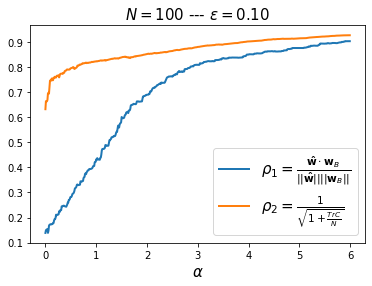

In [16]:
rho_2 = 1 / np.sqrt( 1 + traceC/N )

plt.plot(alpha, rho_, linewidth= 2, color= 'C0', label= r'$\rho_{1} = \frac{{\bf \hat{w}} \cdot {\bf w}_B}{ ||{\bf \hat{w}}|| ||{\bf w}_B ||}$')
plt.plot(alpha, rho_2, linewidth= 2, color= 'C1', label= r'$\rho_{2} = \frac{1}{\sqrt{1 + \frac{Tr C}{N}}}$' )
plt.xlabel(r'$\alpha$', fontsize= 15)
plt.title('$N = %d$ --- $\epsilon = %.2f$' % (N, noise), fontsize= 15)
plt.legend(fontsize= 15)
plt.show()

### $\text{Tr}\{{\cal C}\}/  N$ as function of $\alpha$

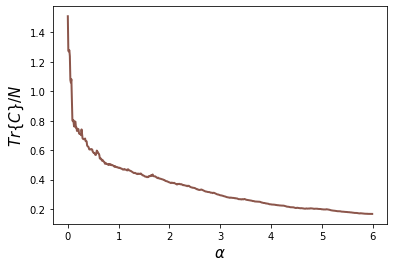

In [36]:
plt.plot(alpha, traceC/N, linewidth= 2, color= 'C5')
plt.xlabel(r'$\alpha$', fontsize= 15)
plt.ylabel(r'$ Tr\{ C \}/  N$', fontsize= 15)
plt.show()

### Mutual Information

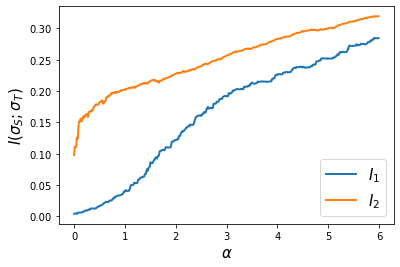

In [29]:
A_rho1 = np.arccos(rho_) / np.pi
A_rho2 = np.arccos(rho_2) / np.pi

I1 = np.log(2) + A_rho1*np.log(A_rho1) + (1 - A_rho1)*np.log(1-A_rho1) 
I2 = np.log(2) + A_rho2*np.log(A_rho2) + (1 - A_rho2)*np.log(1-A_rho2)

plt.plot(alpha, I1, linewidth= 2, color= 'C0', label= r'$I_{1}$')
plt.plot(alpha, I2, linewidth= 2, color= 'C1', label= r'$I_{2}$')

plt.xlabel(r'$\alpha$', fontsize= 15)
plt.ylabel(r'$I(\sigma_S; \sigma_T)$', fontsize= 15)
plt.legend(fontsize= 15, loc= 4)
plt.show()

### Entropy

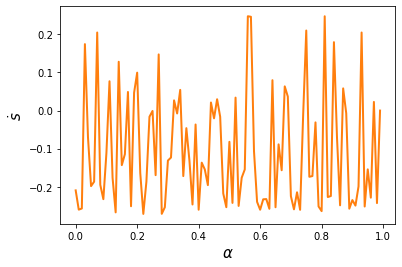

In [31]:
plt.plot(alpha[:100], S_[:100], linewidth= 2, color= 'C1')
plt.xlabel(r'$\alpha$', fontsize= 15)
plt.ylabel(r'$\dot s$', fontsize= 15)
plt.show()

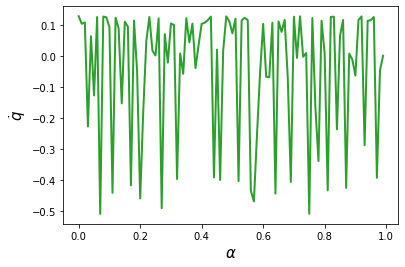

In [34]:
plt.plot(alpha[:100], q_[:100], linewidth= 2, color= 'C2')
plt.xlabel(r'$\alpha$', fontsize= 15)
plt.ylabel(r'$\dot q$', fontsize= 15)
plt.show()

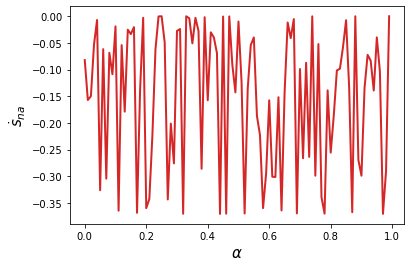

In [35]:
plt.plot(alpha[:100], (S_ + q_)[:100], linewidth= 2, color= 'C3')
plt.xlabel(r'$\alpha$', fontsize= 15)
plt.ylabel(r'${\dot s}_{na}$', fontsize= 15)
plt.show()

### Differential equation for the trace of ${\cal} C$


$$ \frac{dg}{dt} =  \frac{1}{J \sqrt{g} } \int \frac{du}{\sqrt{2\pi} }\partial_u {\cal F}(u) e^{-\frac{g}{2 J^2} u^2} \left(\text{Tr}\kappa -\frac{ {\bf J}  \cdot \kappa {\bf J}}{J^2} \left( 1 - \frac{g}{J^2} u^2   \right) \right) $$

In [39]:
def integrand(x, g, w, C):

    J = w/N
    K = np.matmul(C, C)/N
    J_norm = LA.norm(J)

    Ig = np.exp(- g*x*x / 2*J_norm*J_norm) * dF(x, noise=0.1)*( np.trace(K) - np.dot(J.T, np.matmul(K, J)/J_norm*J_norm)*(1 - x*x*g/J_norm*J_norm))

    return Ig/ J_norm*np.sqrt(2*np.pi)

In [40]:
w = w_[100]

C = C_[100]

g = 1

from scipy.integrate import quad
I = quad(integrand, -np.inf, np.inf, args=(g, w, C))
print(I)

(-0.15767618902174324, 1.4122662754583157e-09)


In [41]:
from scipy.integrate import odeint

def dgdt(g, t, w_, C_):

    epsilon = 0.0001

    I = quad(integrand, -np.inf, np.inf, args=(g, w_, C_))

    dg_dt = I[0] / (g+epsilon)**(0.5)

    return dg_dt

In [42]:
g0 = 1
g = odeint(dgdt, g0, t, args= (w, C))

ValueError: diff requires input that is at least one dimensional

In [38]:
plt.plot(t[0:50], g[0:50], color= 'C', linewidth=2, label = r'$g(t)$')
#plt.plot(t[0:50], 1/np.sqrt(1+ g), color= 'C1', linewidth=2, label = r'$ \frac{1}{\sqrt{1+g(t)}}$')
plt.legend(fontsize= 15)
plt.xlabel(r'$t$', fontsize= 15)
plt.show()

TypeError: 'int' object is not subscriptable

In [108]:
g0 = np.trace(C_[0]) / N
g_sol = []


for j in range(4):

    print('j =', j)


    dt = np.linspace(j, j+1, 10)

    #t = np.arange(M)


    g = odeint(dgdt, g0, dt, args= (w_[j], C_[j]))

    print(g)

    g0 = g[-1]

    print(g0)

    g_sol.append(g)

j = 0


KeyboardInterrupt: 

In [14]:
def eg(x, a):
    return a*(1./x)

In [15]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(eg, alpha, 1-rho_)